In [23]:
import cv2
import numpy as np
import scipy
from scipy.misc import imread
import pickle
import random
import os
import matplotlib.pyplot as plt

In [39]:
image_path = 'queryImages/'
database_path = 'referenceImages/'

In [31]:
import glob
import cv2

# Feature extractor
def extract_features(image_path, vector_size=32):
    image = imread(image_path, mode="RGB")
    try:
        alg = cv2.KAZE_create()
        # Finding image keypoints
        # use glob to grab the image paths and loop over them
        imagePaths = [f for f in glob.glob('directory/*.png')]
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
             dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc


def batch_extractor(database_path, pickled_db_path="kaze_features.pck"):
    files = [os.path.join(database_path, p) for p in sorted(os.listdir(database_path))]

    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
        name = f.split('/')[-1].lower()
        result[name] = extract_features(f)
    
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)

In [32]:
class Matcher(object):

    def __init__(self, pickled_db_path="kaze_features.pck"):
        with open(pickled_db_path, 'rb') as fp:
            self.data = pickle.load(fp)
            self.names = []
            self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=1):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

Query image ==========================================


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


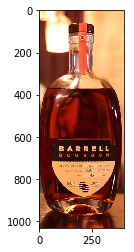

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Result images ========================================
Match 0.7305125171433763


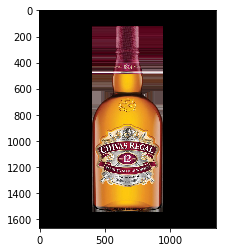

Match 0.7296988045923383


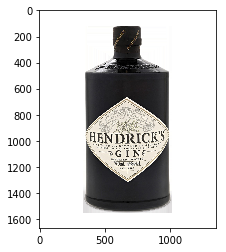

Match 0.7282131545137863


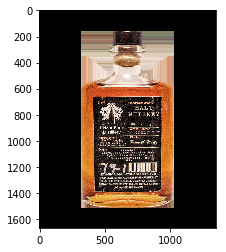

Query image ==========================================


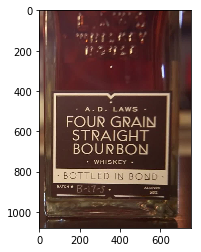

Result images ========================================
Match 0.7774638795163732


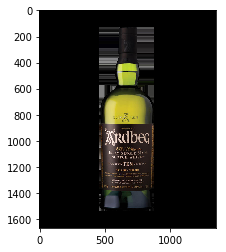

Match 0.7735100089272163


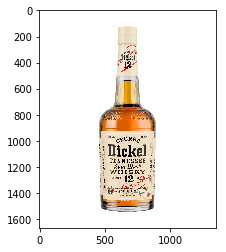

Match 0.7709499754490378


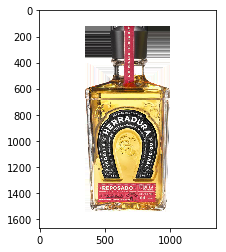

Query image ==========================================


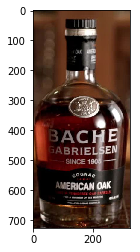

Result images ========================================
Match 0.7689957601509685


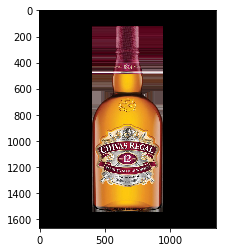

Match 0.7620461809933707


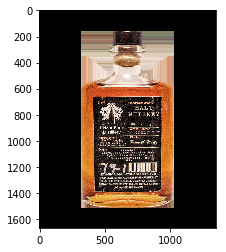

Match 0.7618548583485808


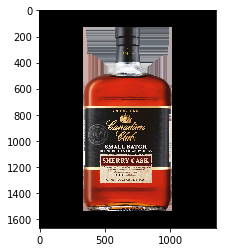

Query image ==========================================


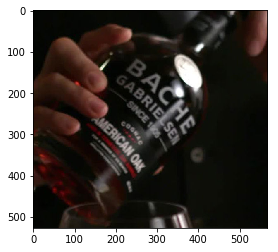

Result images ========================================
Match 0.7766979504660142


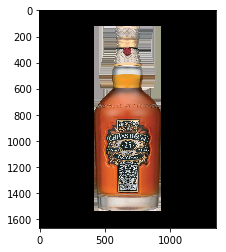

Match 0.7669515139684697


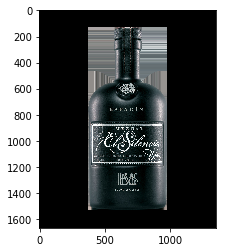

Match 0.7659062326535195


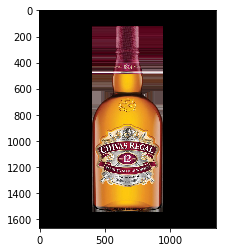

Query image ==========================================


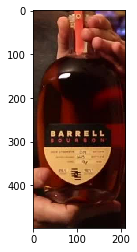

Result images ========================================
Match 0.7472281001394512


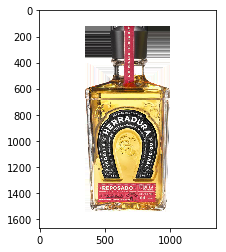

Match 0.7453521570307022


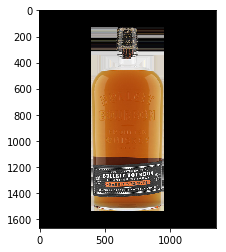

Match 0.7423430749087663


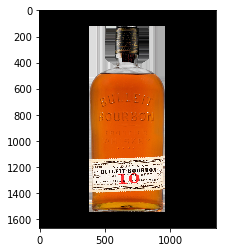

Query image ==========================================


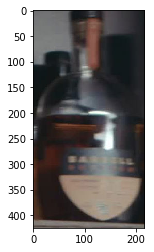

Result images ========================================
Match 0.6838909933329065


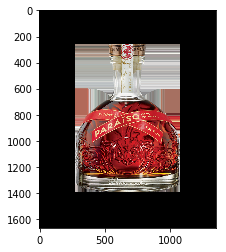

Match 0.6823759856538689


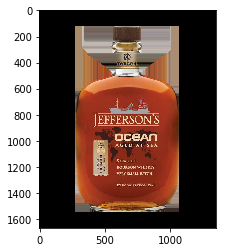

Match 0.6815131973883789


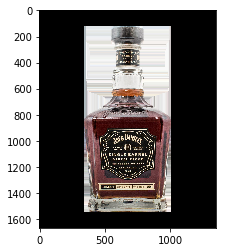

Query image ==========================================


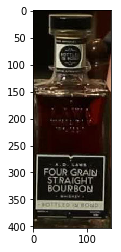

Result images ========================================
Match 0.6806281577035257


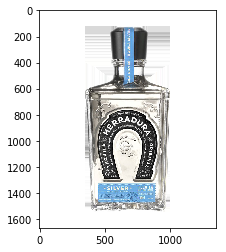

Match 0.6703089729129165


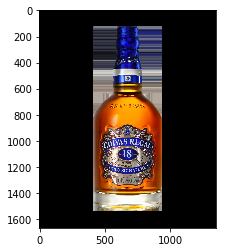

Match 0.6691969264109846


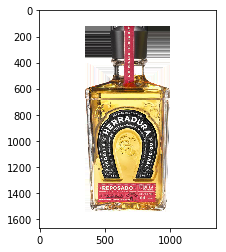

Query image ==========================================


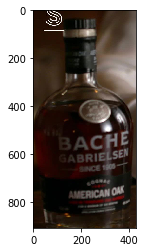

Result images ========================================
Match 0.6609009116769136


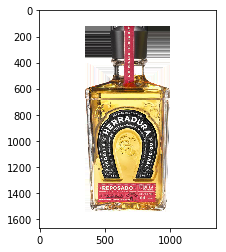

Match 0.6593804363961606


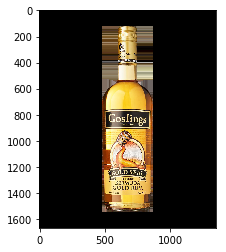

Match 0.6569605160738576


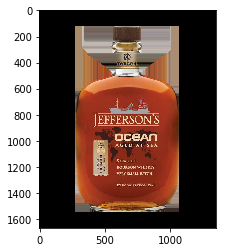

Query image ==========================================


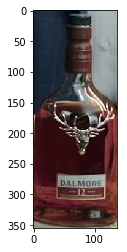

Result images ========================================
Match 0.7076318054898676


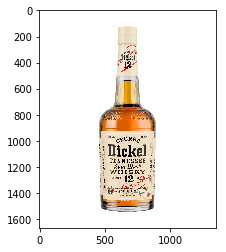

Match 0.694891397285635


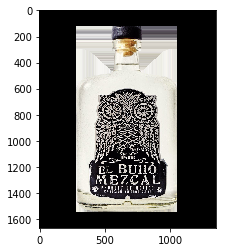

Match 0.6932954859646849


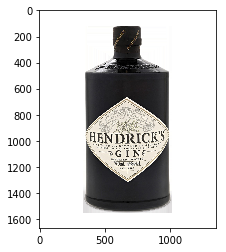

Query image ==========================================


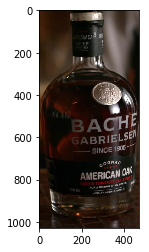

Result images ========================================
Match 0.7710564603226787


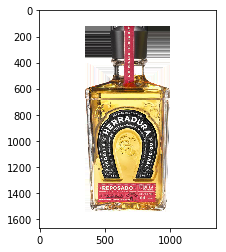

Match 0.7639424802127928


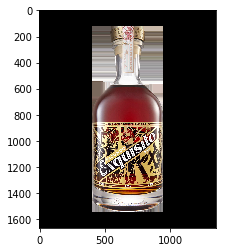

Match 0.7571200165250928


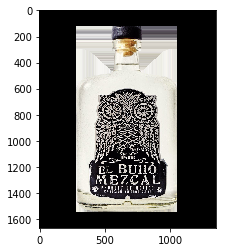

Query image ==========================================


OSError: cannot identify image file 'queryImages/.DS_Store'

In [47]:

def show_img(path):
    img = imread(path, mode="RGB")
    plt.imshow(img)
    plt.show()
    
def run():
    images_path = 'queryImages/'
    database_path = 'referenceImages/'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    # getting 1 random image
    sample = random.sample(files, 11)
    
   # batch_extractor(images_path)

    ma = Matcher('kaze_features.pck')
    
    for s in sample:
        print ('Query image ==========================================')
        show_img(s)
        names, match = ma.match(s, topn=3)
        print ('Result images ========================================')
        for i in range(3):
            # we got cosine distance, less cosine distance between vectors
            # more they similar, thus we subtruct it from 1 to get match value
            print ('Match %s' % (1-match[i]))
            show_img(os.path.join(database_path, names[i]))

run()